In [1]:
#LIBRARIES
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
import math 
## FUZZY
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

## nomalice parameters
from unidecode import unidecode

import spacy  # For preprocessing
from scipy import spatial
from time import time  # To time our operations
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import pylab as P

In [2]:
DF_JOB_H = pd.read_excel("final_DB_extended.xlsx")


In [3]:
DF_JOB_H["job_history_clean"]
def isNaN(testS):
    return not type(testS) == str and  math.isnan(testS)==True
def convertInt(stringIn):
    try:
        return int(stringIn)
    except ValueError:
        print("error int", stringIn)
        return 2021

In [4]:
from deep_translator import GoogleTranslator
def translateString(to_translate, languageFinal):
    valid =isNaN(to_translate)
    #print(valid)
    try:
        translated = GoogleTranslator(source='auto', target=languageFinal).translate("no" if valid else to_translate)
        return translated
    except : 
        print(to_translate)
        return "no"
nlp = spacy.load("en_core_web_sm")

def cleaning(text):
    ##text = text.lower()
    #text = text.replace('[>/,\.!?\-!?\n\)\(\r]', ' ') 
    text = re.sub("[^A-Za-z']+", ' ', str(text))
    doc = nlp(text)
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    #txt = [token.lemma_ for token in doc if not token.is_stop]
    txt = [tok.lemma_.lower() for tok in doc
                if not tok.is_stop and not tok.is_punct and tok.is_alpha ]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    return txt

In [5]:
isNaN("10")

False

In [35]:
## object maker
def stringToObject(DataFrame):
    #SEPARANDO LOS STRINGS DE CADA TRABAJO

    L = []

    for i in DataFrame.job_history_before:
        l = str(i).split("},") #convertir en string el job history del individuo y crear lista para separar cada formación
        k = [] #Lista donde se almacenara cada formación x del individuo i
        for job in l: #para cada trabajo
            job = job.replace("[", "").replace("]", "") + "}" #separelos y conviertalas en diccionarios
            k.append(job) #añadalas a la lista de jobs
        L.append(k) 
    #EXTRAER DE MANERA ORDENADA EL JOB HISTORY, LA FECHA DE TERMINACIÓN Y COMIENZO
    K = [] 
    index = 0
    for individuo in tqdm(L): 

        educacion_ind = [] 

        for ins in individuo: 
            #print(ins, type(ins))
            ins = ins.replace('"', "'")

            c = {}

            #EXTRAER JOB-TITLE
            if ( len(re.findall("'job_title': '.*?'", ins)) ) > 0:
                c["job_title"] =  re.findall("'job_title': '.*?'", ins)[0].replace("'job_title': ", "").replace("'", "")
                c["job_title"] = str(c["job_title"])
                # c["job_title"] = cleaning(c["job_title"])

            #EXTRAER INICIO
            if ( len(re.findall("'start': '.*?'", ins)) ) > 0:
                c["start"] = re.findall("'start': '.*?'", ins)[0].replace("'start': ", "").replace("'", "")
                c["start"] = convertInt(c["start"][::-1][0:4][::-1]) #SOLO CONSERVAR EL AÑO 

            #EXTRAER FINALIZACIÓN
            if ( len(re.findall("'end': '.*?'", ins)) ) > 0:
                c["end"] = re.findall("'end': '.*?'", ins)[0].replace("'end': ", "").replace("'", "")
                c["end"] = convertInt(c["end"][::-1][0:4][::-1]) #SOLO CONSERVAR EL AÑO
            if index < 20:
                print(ins,c)
            educacion_ind.append(c) #añado cada formación a la lista de sus educaciones
        job_current = {'job_title': DataFrame["job_title"][index]}
        #print(job_current)
        educacion_ind.append(job_current)

        K.append(educacion_ind) #añado la educación de cada individuo a una lista general
        index += 1 
    return K

    

In [36]:
result = stringToObject(DF_JOB_H)
print(result[0])


100%|██████████| 1004/1004 [00:00<00:00, 8959.25it/s]} {}
} {}
{'job_title': 'head of payment methods and electronic banking ', 'start': '2013'} {'job_title': 'head of payment methods and electronic banking ', 'start': 2013}
 {'job_title': 'college professor', 'start': '2014', 'end': '2014'} {'job_title': 'college professor', 'start': 2014, 'end': 2014}
 {'job_title': 'specialized operations professional', 'start': '2011', 'end': '2013'} {'job_title': 'specialized operations professional', 'start': 2011, 'end': 2013}
 {'job_title': 'senior operations analyst', 'start': '2009', 'end': '2011'} {'job_title': 'senior operations analyst', 'start': 2009, 'end': 2011}
 {'job_title': 'international operations analyst', 'start': '2008', 'end': '2009'} {'job_title': 'international operations analyst', 'start': 2008, 'end': 2009}
 {'job_title': 'treasury back office analyst ', 'start': '2006', 'end': '2008'} {'job_title': 'treasury back office analyst ', 'start': 2006, 'end': 2008}
 {'job_title':

In [30]:
result[10]

[{'job_title': 'graphic design', 'start': 2015},
 {'job_title': 'head of customer service', 'start': 2011, 'end': 2015},
 {'job_title': 'sales training and administration',
  'start': 2006,
  'end': 2011},
 {'job_title': 'secretary of direction', 'start': 2004, 'end': 2006},
 {'job_title': 'Diseñadora gráfica'}]

In [31]:
len(result)

1004

In [10]:

embeddings_dict = {}
# vectors dimention
DIMENTION_DIC = 300
# 6 billions words
#with open("glove.6B."+str(DIMENTION_DIC)+"d.txt", 'r', encoding="utf-8") as f:
# 42 Billion words
with open("glove.42B."+str(DIMENTION_DIC)+"d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        print(word)
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

        

ney/redi-meds
stalwartuk
st-amant
stamp-size
stanchorage
s.t.a.n.d.
standord
starfox64
starle
starmind
star-san
starselite
starsports
starspow
starsshineonme
start/continue
start.html
starthtml
star-type
starvox
starwagon
stasso
state10
statec
statementlicense
state.now
state-reported
states10/10/2012
statesquick
statesthere
states.washington
state_type
stateview
stathams
station/bryan
stationthis
statkevich
statsanswersboardvideos
statti
stay-awake
staybeautiful
stboise
std100
stduluth
steamfunk
steapon
steece
steelers/ravens
steelroots
stefanibags.com
steinhour
stellenbosh
step.if
stepkother
stepo
stepsjoincontact
step-step
stepups
steri-fab
sterioids
sterlinglogin
sternn
steroided
stevn
stgc
sthd
stnto
stock11
stock.estimated
stockfinster
stockholme
stockpickers
stockpiler
stocks.com
stockwarning
stocs
stokeham
stoke-on
stolder
stommelen
stone-covered
stooop
stopgame
stop/limit
storandt
storesbusinesses
stormclan
störmer
storm-relative
storyfebruary
story?follow
storywriters
stossel

In [11]:
## ordena la spalabras dependiendo de la distancia euclidiana en el n-space
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

## method to get word/vector from dictionary
def getVectorWord(dictionary, word):
    if word in dictionary:
        return dictionary[word]
    else :
        return np.zeros(DIMENTION_DIC)


In [12]:
DF_JOB_H["end_boot"][200]

2017

In [13]:
np.add.reduce([np.zeros(3)])

array([0., 0., 0.])

In [37]:
## tranform profiles to vectors
profilesVectors = []
profilesVectorPlain = []
for index in range(0,len(result)):
    job_history_prof = result[index]
    boot_year = DF_JOB_H["end_boot"][index]
    boot_year = int(boot_year) if not type(boot_year) ==str  and not math.isnan(boot_year)  else float("nan")
    total_jobs = len(job_history_prof)
    job_vectors = []
    print(index)
    for i in range(0,total_jobs):
        if ("start" in job_history_prof[i] and "job_title" in job_history_prof[i] and boot_year and not math.isnan(boot_year) and not type(boot_year) ==str  and job_history_prof[i]["start"]>=int(boot_year)) :
            job_title = job_history_prof[i]["job_title"]
            job_title_en = translateString(job_title,"en")
            cleaned = cleaning(job_title_en)
            #print(job_title, len(job_title))
            nVectors = [np.zeros(DIMENTION_DIC)]
            if len(cleaned) > 0:
                nVectors  = [ getVectorWord(embeddings_dict,word) for word in cleaned]
            sumVector = np.add.reduce(nVectors)
            job_vectors.append(sumVector)
            profilesVectorPlain.append(sumVector)

        elif (not "start" in job_history_prof[i] and "job_title" in job_history_prof[i] and  type(job_history_prof[i]["job_title"]) ==str):
            job_title = job_history_prof[i]["job_title"]
            job_title_en = translateString(job_title,"en")
            cleaned = cleaning(job_title_en)
            #print(cleaned, len(cleaned))
            nVectors = [np.zeros(DIMENTION_DIC)]
            if len(cleaned) > 0:
                nVectors  = [ getVectorWord(embeddings_dict,word) for word in cleaned]
            sumVector = np.add.reduce(nVectors)
            #print( len(sumVector))
            job_vectors.append(sumVector)
            profilesVectorPlain.append(sumVector)
        else:
            profilesVectorPlain.append(np.zeros(DIMENTION_DIC))
            job_vectors.append(None)
    profilesVectors.append(job_vectors)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
len(profilesVectorPlain[6396])

In [38]:
## number of words needed to pass
MIN_COUNT = 2
## validates if is word related
def validator(relatedWords, words):
    isRelated = False
    count = 0
    for word in words:
        if word in relatedWords:
            count+=1
        if count >= MIN_COUNT: 
            return True
    if count >= MIN_COUNT: 
        return True
    else:
        return False

 


In [28]:
print(find_closest_embeddings(profilesVectorPlain[1])[:9])

['web', 'developer', 'website', 'developers', 'site', 'software', 'development', 'websites', 'application']


In [39]:
newVector = []
index = 0
for vec in profilesVectorPlain:
    print(index)
    try:
        lenght = len(vec)
        newVector.append(vec)
        #print(index, len(vec), len(newVector))
    except:
        newVector.append(np.zeros(DIMENTION_DIC))
        print(vec)
    index +=1


489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738

In [40]:
TOTAL_CLUSTERS = 12
#TOTAL_CLUSTERS = 4
dicC = {}
clusterTotal = np.zeros(len(newVector))

related_words = ["software","development","engineer","web","developers","developer","engineering","technical","java","computer","microsoft","technology","programmer"]
for clust in range(2, TOTAL_CLUSTERS+1):
    kmeans = KMeans(n_clusters=clust, random_state=0).fit(newVector)
    labels = kmeans.labels_
    relatedArray = []
    for index in range(0,len(kmeans.cluster_centers_)):
        words = find_closest_embeddings(kmeans.cluster_centers_[index])[:7]
        related = validator(related_words, words)
        print(index,related," - ",words)
        relatedArray.append(related)
    print(len(relatedArray),clust, len(clusterTotal))
    for proIndex in range(0,len(labels)):
        label = labels[proIndex]
        isRelated = relatedArray[label]
        if isRelated==True:
            print("isRelated")
            prev = clusterTotal[proIndex]
            clusterTotal[proIndex] = prev + 1
            print(prev,clusterTotal[proIndex])
    print("------------------------------------------\n")

ated
8.0 9.0
isRelated
7.0 8.0
isRelated
7.0 8.0
isRelated
7.0 8.0
isRelated
4.0 5.0
isRelated
7.0 8.0
isRelated
8.0 9.0
isRelated
6.0 7.0
isRelated
7.0 8.0
isRelated
7.0 8.0
isRelated
8.0 9.0
isRelated
7.0 8.0
isRelated
7.0 8.0
isRelated
7.0 8.0
isRelated
7.0 8.0
isRelated
7.0 8.0
isRelated
5.0 6.0
isRelated
7.0 8.0
isRelated
8.0 9.0
isRelated
8.0 9.0
isRelated
8.0 9.0
isRelated
8.0 9.0
isRelated
8.0 9.0
isRelated
7.0 8.0
isRelated
7.0 8.0
isRelated
7.0 8.0
isRelated
6.0 7.0
isRelated
4.0 5.0
isRelated
7.0 8.0
isRelated
7.0 8.0
isRelated
8.0 9.0
isRelated
8.0 9.0
isRelated
8.0 9.0
isRelated
8.0 9.0
isRelated
8.0 9.0
isRelated
7.0 8.0
isRelated
7.0 8.0
isRelated
7.0 8.0
isRelated
6.0 7.0
isRelated
8.0 9.0
isRelated
8.0 9.0
isRelated
7.0 8.0
isRelated
8.0 9.0
isRelated
7.0 8.0
isRelated
8.0 9.0
isRelated
7.0 8.0
isRelated
8.0 9.0
isRelated
8.0 9.0
isRelated
8.0 9.0
isRelated
8.0 9.0
isRelated
7.0 8.0
isRelated
8.0 9.0
isRelated
8.0 9.0
isRelated
6.0 7.0
isRelated
7.0 8.0
isRelated
7.0 8

## max number in any job is 9, 

In [31]:
print(np.max(clusterTotal))

11.0


## after distribution, almost all related jobs

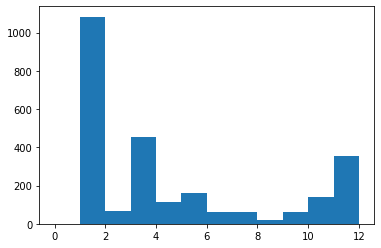

In [32]:
n, bins, patches = P.hist(clusterTotal,bins=[0,1,2,3,4,5,6,7,8,9,10,11,12])
P.show()

## before distribution, almost no related jobs

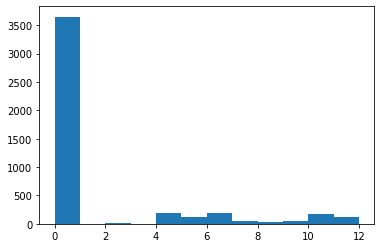

In [41]:

n, bins, patches = P.hist(clusterTotal,bins=[0,1,2,3,4,5,6,7,8,9,10,11,12])
P.show()

In [ ]:
len(clusterTotal)

In [ ]:
len(profilesVectors[0])

## to group back the data


In [42]:
totalIndex = 0
finalDic = {}
finalDic["HAD_RELATED"] = []
finalDic["POSITIVE_JOBS"] = []
finalDic["POSIBLE_JOBS"] = []
finalDic["TOTAL_JOBS"] = []
for profile in profilesVectors:
    lenP = len(profile)
    #print("total JOBs", lenP)
    totalPosJobs = 0
    possibleJobs = 0
    hadRealted = False
    ## se recorre el array de jobs para este perfil
    for jobI in range(0,lenP):
        job = profile[jobI]
        print(jobI,type(job) )
        if  type(job) == np.ndarray : 
            countSingleJob = clusterTotal[totalIndex]
            print(countSingleJob)
            possibleJobs+=1
            if countSingleJob>3:
                hadRealted = True
                totalPosJobs+=1
            totalIndex+=1
        else:
            totalIndex+=1
    finalDic["HAD_RELATED"].append(hadRealted)
    finalDic["POSITIVE_JOBS"].append(totalPosJobs)
    finalDic["POSIBLE_JOBS"].append(possibleJobs)
    finalDic["TOTAL_JOBS"].append(lenP)

print(len(clusterTotal),totalIndex,finalDic)


py.ndarray'>
4.0
0 <class 'NoneType'>
1 <class 'NoneType'>
2 <class 'NoneType'>
3 <class 'NoneType'>
4 <class 'NoneType'>
5 <class 'NoneType'>
6 <class 'NoneType'>
7 <class 'NoneType'>
8 <class 'numpy.ndarray'>
9.0
0 <class 'NoneType'>
1 <class 'NoneType'>
2 <class 'NoneType'>
3 <class 'numpy.ndarray'>
4.0
0 <class 'NoneType'>
1 <class 'NoneType'>
2 <class 'NoneType'>
3 <class 'NoneType'>
4 <class 'numpy.ndarray'>
4.0
0 <class 'NoneType'>
1 <class 'NoneType'>
2 <class 'NoneType'>
3 <class 'NoneType'>
4 <class 'NoneType'>
5 <class 'NoneType'>
6 <class 'NoneType'>
7 <class 'numpy.ndarray'>
4.0
0 <class 'NoneType'>
1 <class 'NoneType'>
2 <class 'numpy.ndarray'>
6.0
0 <class 'NoneType'>
1 <class 'NoneType'>
2 <class 'numpy.ndarray'>
4.0
0 <class 'NoneType'>
1 <class 'numpy.ndarray'>
5.0
0 <class 'NoneType'>
1 <class 'NoneType'>
2 <class 'NoneType'>
3 <class 'NoneType'>
4 <class 'NoneType'>
5 <class 'NoneType'>
6 <class 'numpy.ndarray'>
6.0
0 <class 'NoneType'>
1 <class 'NoneType'>
2 <class

In [43]:

JOB_HIST_CLUS_DF = pd.DataFrame(finalDic)
JOB_HIST_CLUS_DF.to_excel("count_history_index_before.xlsx",index=False)
print(JOB_HIST_CLUS_DF, JOB_HIST_CLUS_DF.shape)

      HAD_RELATED  POSITIVE_JOBS  POSIBLE_JOBS  TOTAL_JOBS
0            True              1             1           2
1           False              0             1           2
2            True              1             1          16
3           False              0             1           4
4           False              0             1           7
...           ...            ...           ...         ...
999          True              1             1           6
1000         True              1             1           2
1001         True              1             1           3
1002        False              0             1           4
1003         True              1             1           4

[1004 rows x 4 columns] (1004, 4)
